## 1. Import Libraries

In [1]:
from tensorflow import keras as ks
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import time
import random
import datetime

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model

# 2. VGG16 for Transfer Learning

We are going to load the extraction feature part from the VGG16 architecture 

In [2]:
vgg = vgg16.VGG16(include_top=False,
                  weights="imagenet",
                  input_shape=(32, 32, 3)
                  )

In [3]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [4]:
output = vgg.layers[-1].output
new_output_layer = ks.layers.Flatten()(output)
vgg_model = Model(vgg.input, new_output_layer)

In [5]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [6]:
vgg_model.trainable = False

for layer in vgg_model.layers:
  layer.trainable = False

trainable = False
for layer in vgg_model.layers:
  if layer.name == "block4_conv1":
    trainable = True
  layer.trainable = trainable

In [7]:
pd.set_option("max_colwidth", None)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=["Layer Type", "Layer Name", "Layer Trainable"])

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f0b8dcd6150>,input_1,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f0b83aec610>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f0bc99cfd10>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f0b838e3d10>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f0b701611d0>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f0b7016f1d0>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f0b70161090>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f0b70173ad0>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f0b7017d490>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f0b70181dd0>,block3_conv3,False


## 2. Neural Newtork Architecture


In [8]:
input_shape = vgg_model.output_shape[1]
print(f"Input shape: {input_shape}")

Input shape: 512


In [9]:
model_post_vgg = ks.Sequential()

model_post_vgg.add(vgg_model)

model_post_vgg.add(ks.layers.Dense(128, activation="relu", input_shape=(input_shape,)))
model_post_vgg.add(ks.layers.BatchNormalization())
model_post_vgg.add(ks.layers.Dropout(0.5))

model_post_vgg.add(ks.layers.Dense(256, activation="relu", input_shape=(input_shape,)))
model_post_vgg.add(ks.layers.BatchNormalization())
model_post_vgg.add(ks.layers.Dropout(0.5))

model_post_vgg.add(ks.layers.Dense(256, activation="relu"))
model_post_vgg.add(ks.layers.BatchNormalization())
model_post_vgg.add(ks.layers.Dropout(0.5))

model_post_vgg.add(ks.layers.Dense(10, activation="softmax"))

In [10]:
model_post_vgg.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

## 3. Cost function


In [11]:
#adam = Adam(learning_rate=2e-5)

In [12]:
model_post_vgg.compile(optimizer="Adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

## 4. Data Preparation

We load the CIFAR10 dataset directly from Keras. Those are already split in train and test.


**Important:** 
> The neural network requires for the inputs to be real numbers. We can simply achieve this by divinding the values inside the matrices by 255.0.

In [13]:
cifar10 = ks.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0

In [14]:
y_train_label = y_train

#y_test = ks.utils.to_categorical(y_test)
#y_train = ks.utils.to_categorical(y_train)

y_test
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [15]:
cifar10_labels = [
'airplane', # id 0
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck',
]

print('Number of labels: %s' % len(cifar10_labels))

Number of labels: 10


Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


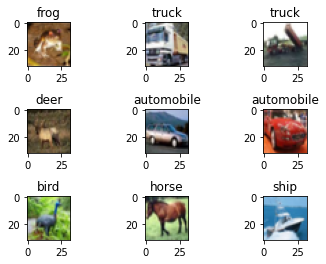

In [16]:
# Let's plot a sample of the images

print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

for i in range(9):

    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.title(cifar10_labels[y_train_label[i,0]])

plt.subplots_adjust(hspace = 1)
plt.show()

In [17]:
x_val = x_train[-10000:]
y_val = y_train[-10000:]

x_train = x_train[:-10000]
y_train = y_train[:-10000]


When we add convolutions, we need to preprocess the data, because **convolution is for an array of 4 fields** (more like "images"), not an array of 3 dimensions as the datasets for train, test and validation. So we need to **.reshape()**.

That's why, when you exit the convolution, you have to flatten the matrices, because the FullDense layers expect arrays, not matrices!


In [18]:
# Let's validate the results
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))

Train: X=(40000, 32, 32, 3), y=(40000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)
Validation: X=(10000, 32, 32, 3), y=(10000, 1)


# 4. Early Stopping & Checkpoint

In [19]:
callback_loss = EarlyStopping(monitor="val_loss", patience=15)
callback_accuracy = EarlyStopping(monitor="val_accuracy", patience=10)

In [20]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = ks.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

## 5. Training

Note that we have to train against the data converted to the format expected by the Convolution.

We will start with 30 epochs, that is to say, 30 complete passes of the dataset (which in turn will be with mini-batches internally, setting the batches to 64 elements.

The .fit() method allows us to define if we have several CPUs, GPUs, and if we want to validate data at each end of epoch.

In [21]:
t = time.perf_counter()

In [22]:
history = model_post_vgg.fit(x_train, y_train, 
                    epochs=300, 
                    use_multiprocessing=False, 
                    batch_size= 512, 
                    callbacks=[callback_accuracy, callback_loss, model_checkpoint_callback],
                    validation_data=(x_val, y_val))

Epoch 1/300
79/79 [==============================] - 14s 102ms/step - loss: 2.4299 - accuracy: 0.2636 - val_loss: 1.9364 - val_accuracy: 0.3018
Epoch 2/300
79/79 [==============================] - 5s 67ms/step - loss: 1.8233 - accuracy: 0.3783 - val_loss: 1.6575 - val_accuracy: 0.4178
Epoch 3/300
79/79 [==============================] - 5s 68ms/step - loss: 1.6229 - accuracy: 0.4308 - val_loss: 1.4401 - val_accuracy: 0.5006
Epoch 4/300
79/79 [==============================] - 5s 68ms/step - loss: 1.5102 - accuracy: 0.4681 - val_loss: 1.3226 - val_accuracy: 0.5395
Epoch 5/300
79/79 [==============================] - 5s 68ms/step - loss: 1.4518 - accuracy: 0.4906 - val_loss: 1.2751 - val_accuracy: 0.5519
Epoch 6/300
79/79 [==============================] - 5s 68ms/step - loss: 1.4061 - accuracy: 0.5032 - val_loss: 1.2580 - val_accuracy: 0.5573
Epoch 7/300
79/79 [==============================] - 5s 67ms/step - loss: 1.3769 - accuracy: 0.5201 - val_loss: 1.2340 - val_accuracy: 0.5671
Epoc

In [23]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Tiempo de entrenamiento:', elapsed_time)

Tiempo de entrenamiento: 0:05:01.854801


In [24]:
model_post_vgg.load_weights(checkpoint_filepath)

## 6. Results Evaluation

Let's obtain a graph of how the error and accuracy evolve at each epoch in the training and validation data.

In [25]:
_, acc = model_post_vgg.evaluate(x_test, y_test, verbose=0)
print('> %.3f' % (acc * 100.0))

> 60.420


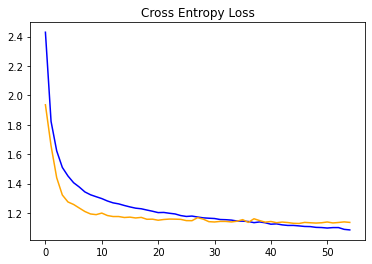

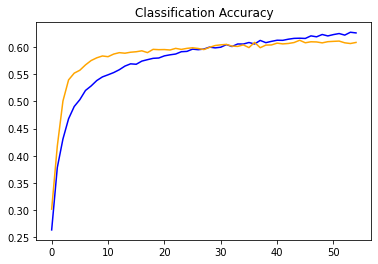

In [26]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.show()

The cost we can see that it is stable and it is at epoch 15 that it is fixed at a value. Also the accuracy dances around 0.10. We can't say that it is a very good model.

Let's see what kind of predictions I'm getting on the test set (let's paint the images and their classifications)

In [27]:
predictions = model_post_vgg.predict(x_test)

In [28]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label[0]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label[0]].set_color('blue')

We draw the first images, with the predictions and their real values (a total of 20 images, so as not to abuse your laptops).

We color the correct predictions in blue and the failures in red. But first I have printed the labels so that we have a reference to the graph.

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


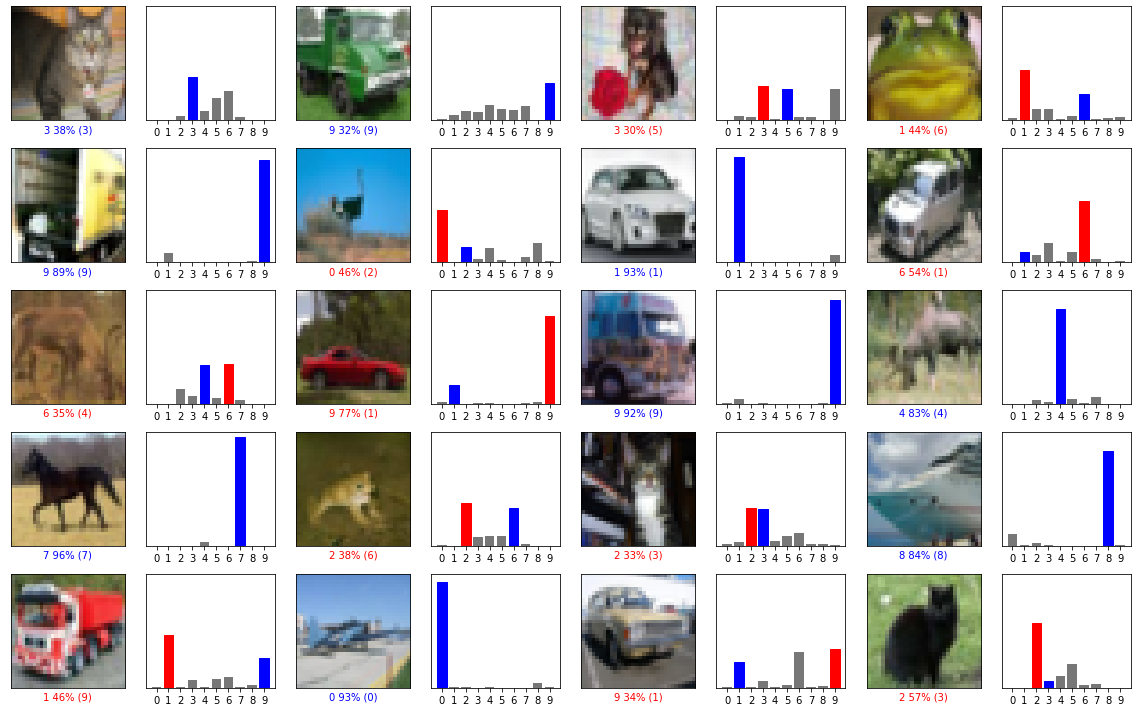

In [29]:
i = 0
for l in cifar10_labels:
    print(i, l)
    i += 1

num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i+start, predictions[i+start], y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()